Collected 24 unique bonds (counting orientation).
Global minimum eigenvalue = -1.500000 at (u,v)=(-0.0333,-0.0033)
q_min (cartesian) = [-0.076794, -0.108828]


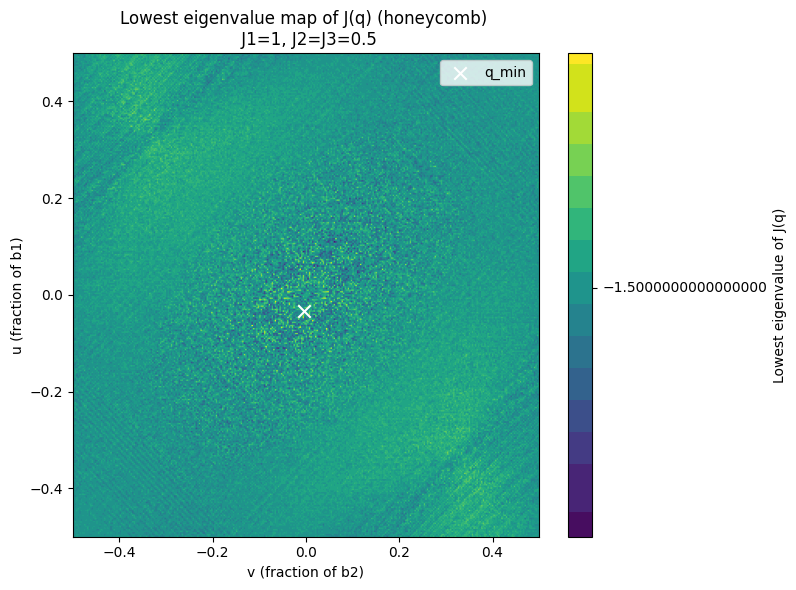

Eigenvalues at q_min: [-1.5         7.42043107]
Eigenvector (complex) for lowest band: [-0.70710678+0.j          0.70710677-0.00013454j]


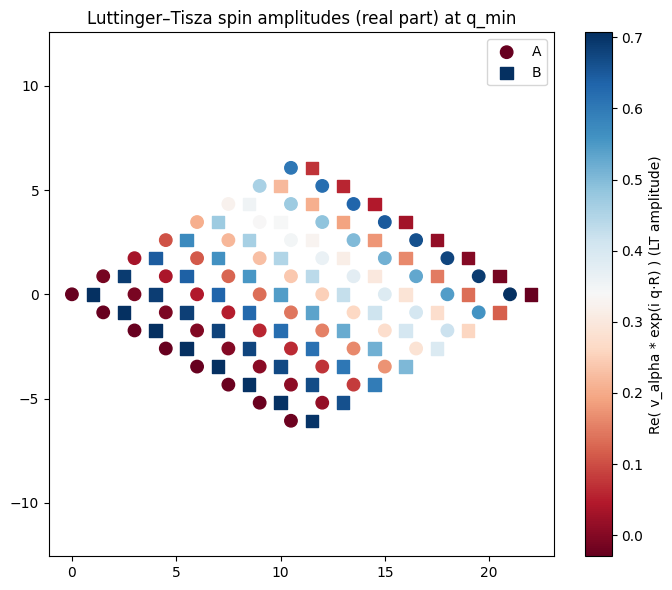

Results saved to Jq_results.npz


In [1]:
# j_q_honeycomb.py
# Compute J(q) for honeycomb lattice with J2=J3=J1/2, plot lowest eigenvalue map,
# find q where the minimum occurs, and show the LT spin pattern at q_min.
#
# Dependencies: numpy, matplotlib
# Run: python j_q_honeycomb.py  (or run cells in a Jupyter notebook)

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi

# -------------------------
# Parameters (changeable)
# -------------------------
J1 = 1.0
J2 = 0.5 * J1
J3 = 0.5 * J1

# q-grid sampling in fractional coordinates of reciprocal vectors (u,v)
Nq = 301             # grid resolution (odd is convenient for center)
u_vals = np.linspace(-0.5, 0.5, Nq)
v_vals = np.linspace(-0.5, 0.5, Nq)

# size used to collect bond vectors (must capture up to 3rd neighbors)
cell_range = 3       # search integer translations di,dj in [-cell_range, cell_range]

# -------------------------
# Lattice definition
# -------------------------
# Use a conventional honeycomb embedding:
# Bravais vectors (chosen such that nearest-neighbor distance = 1, basis at (0,0) and (1,0))
a1 = np.array([1.5,  np.sqrt(3)/2.0])   # as used commonly for honeycomb (graphene)
a2 = np.array([1.5, -np.sqrt(3)/2.0])

# Sublattice basis positions inside unit cell (A and B)
rA = np.array([0.0, 0.0])
rB = np.array([1.0, 0.0])

# We'll assemble lattice sites of a small supercell to enumerate bond vectors
Lx = 6   # number of cells in a1 direction (sufficient to capture up to 3rd neighbor)
Ly = 6
sites = []
for i in range(Lx):
    for j in range(Ly):
        R = i*a1 + j*a2
        sites.append((R + rA, 0, (i,j)))   # sublattice A -> label 0
        sites.append((R + rB, 1, (i,j)))   # sublattice B -> label 1

positions = np.array([s[0] for s in sites])
subl = np.array([s[1] for s in sites])

# -------------------------
# Identify bond vectors and assign Jij
# -------------------------
# Typical distances for our embedding:
d_J1 = 1.0
d_J2 = sqrt(3.0)
d_J3 = 2.0
tol = 1e-3

bond_list = []   # will hold tuples (subl_a, subl_b, vec_ab, Jij)

num_sites = len(positions)
for i in range(num_sites):
    ri = positions[i]
    ai = subl[i]
    for j in range(num_sites):
        if i == j:
            continue
        # find minimal image vector r_j + T - r_i with T = n1*a1 + n2*a2, search small range
        best_vec = None
        best_d = 1e9
        for n1 in range(-cell_range, cell_range+1):
            for n2 in range(-cell_range, cell_range+1):
                shift = n1*a1 + n2*a2
                vec = positions[j] + shift - ri
                d = np.linalg.norm(vec)
                if d < best_d:
                    best_d = d
                    best_vec = vec
        if abs(best_d - d_J1) < tol:
            Jij = J1
        elif abs(best_d - d_J2) < tol:
            Jij = J2
        elif abs(best_d - d_J3) < tol:
            Jij = J3
        else:
            continue
        bond_list.append((ai, subl[j], best_vec, Jij))

# remove duplicates (same subl_a, subl_b, vector up to rounding)
unique = {}
for a,b,vec,Jij in bond_list:
    key = (int(a), int(b), tuple(np.round(vec,6)))
    if key not in unique:
        unique[key] = (int(a), int(b), np.array(vec), float(Jij))
bonds = list(unique.values())

print(f"Collected {len(bonds)} unique bonds (counting orientation).")
# -------------------------
# Reciprocal lattice vectors
# -------------------------
# area = a1_x * a2_y - a1_y * a2_x
area = np.cross(a1, a2)
b1 = 2*pi * np.array([ a2[1], -a2[0] ]) / area
b2 = 2*pi * np.array([ -a1[1], a1[0] ]) / area

# Helper: construct J(q)
def J_of_q(qvec):
    """Return 2x2 complex Hermitian J(q) matrix for given q vector (cartesian)."""
    Jq = np.zeros((2,2), dtype=complex)
    for a,b,vec,Jij in bonds:
        phase = np.exp(1j * np.dot(qvec, vec))
        Jq[a, b] += Jij * phase
    # ensure Hermitian (numerical symmetrization)
    Jq = 0.5*(Jq + Jq.conj().T)
    return Jq

# -------------------------
# Scan BZ on grid
# -------------------------
eig_min_map = np.zeros((Nq, Nq))
eig_max_map = np.zeros((Nq, Nq))

for iu, u in enumerate(u_vals):
    for iv, v in enumerate(v_vals):
        qvec = u * b1 + v * b2      # cartesian q
        Jq = J_of_q(qvec)
        eigs = np.linalg.eigvalsh(Jq)    # returns sorted real eigenvalues
        eig_min_map[iu, iv] = eigs[0]
        eig_max_map[iu, iv] = eigs[-1]

# -------------------------
# Find global minimum
# -------------------------
min_idx = np.unravel_index(np.argmin(eig_min_map), eig_min_map.shape)
u_min, v_min = u_vals[min_idx[0]], v_vals[min_idx[1]]
qmin_vec = u_min * b1 + v_min * b2
min_value = eig_min_map[min_idx]
print(f"Global minimum eigenvalue = {min_value:.6f} at (u,v)=({u_min:.4f},{v_min:.4f})")
print(f"q_min (cartesian) = [{qmin_vec[0]:.6f}, {qmin_vec[1]:.6f}]")

# -------------------------
# Plot lowest eigenvalue map
# -------------------------
plt.figure(figsize=(8,6))
# imshow expects [x_min,x_max] for extent horizontally; we map v on x-axis and u on y-axis
extent = [v_vals[0], v_vals[-1], u_vals[0], u_vals[-1]]
im = plt.imshow(eig_min_map, origin='lower', extent=extent, aspect='auto')
plt.colorbar(im, label='Lowest eigenvalue of J(q)')
plt.scatter([v_min], [u_min], color='white', marker='x', s=80, label='q_min')
plt.xlabel('v (fraction of b2)')
plt.ylabel('u (fraction of b1)')
plt.title('Lowest eigenvalue map of J(q) (honeycomb) \n J1=1, J2=J3=0.5')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Optionally: compute eigenvector at q_min and plot LT spin pattern
# -------------------------
Jqmin = J_of_q(qmin_vec)
eigs, vecs = np.linalg.eigh(Jqmin)   # vecs columns are eigenvectors
# eigenvector corresponding to lowest eigenvalue is vecs[:, 0]
vmin = vecs[:, 0]
# Normalize
vmin = vmin / np.linalg.norm(vmin)
print("Eigenvalues at q_min:", eigs)
print("Eigenvector (complex) for lowest band:", vmin)

# Construct spin configuration in real space from the LT eigenvector:
# For Lx x Ly supercell we show phases on A and B sublattices: S_Rα = Re( v_α * exp(i q·R) )
# where α=0,1 are sublattices (A,B) and R is Bravais-lattice vector for each unit cell.
ncells_to_show = 8
Rlist = []
S_A = []
S_B = []
for i in range(ncells_to_show):
    for j in range(ncells_to_show):
        R = i*a1 + j*a2
        phase = np.exp(1j * np.dot(qmin_vec, R))
        SA = (vmin[0] * phase).real
        SB = (vmin[1] * phase).real
        Rlist.append(R)
        S_A.append(SA)
        S_B.append(SB)

Rlist = np.array(Rlist)
S_A = np.array(S_A)
S_B = np.array(S_B)

plt.figure(figsize=(7,6))
# Plot sublattice A points colored by SA value (scalar along e.g. x)
plt.scatter(Rlist[:,0] + rA[0], Rlist[:,1] + rA[1], c=S_A, marker='o', s=80, cmap='RdBu', label='A')
plt.scatter(Rlist[:,0] + rB[0], Rlist[:,1] + rB[1], c=S_B, marker='s', s=80, cmap='RdBu', label='B')
plt.colorbar(label='Re( v_alpha * exp(i q·R) ) (LT amplitude)')
plt.title('Luttinger–Tisza spin amplitudes (real part) at q_min')
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# Save results optionally
np.savez("Jq_results.npz", u_vals=u_vals, v_vals=v_vals, eig_min_map=eig_min_map,
         eig_max_map=eig_max_map, u_min=u_min, v_min=v_min, min_value=min_value)
print("Results saved to Jq_results.npz")


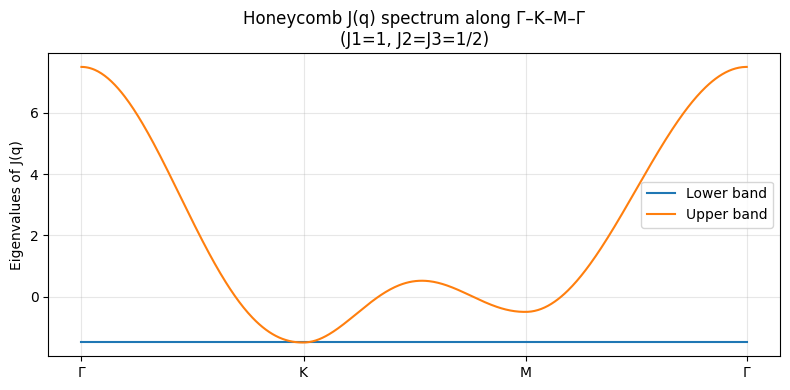

In [2]:
# j_q_HSP.py
# High-symmetry path Γ-K-M-Γ band structure for honeycomb J(q)
# J2 = J3 = J1/2

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi

# Parameters
J1 = 1.0
J2 = 0.5 * J1
J3 = 0.5 * J1
cell_range = 3

# Honeycomb lattice
a1 = np.array([1.5,  np.sqrt(3)/2.0])
a2 = np.array([1.5, -np.sqrt(3)/2.0])
rA = np.array([0.0, 0.0])
rB = np.array([1.0, 0.0])

# Supercell to enumerate bonds
Lx = 6
Ly = 6
sites = []
for i in range(Lx):
    for j in range(Ly):
        R = i*a1 + j*a2
        sites.append((R + rA, 0))
        sites.append((R + rB, 1))

positions = np.array([s[0] for s in sites])
subl = np.array([s[1] for s in sites])

# Bond lengths (given the embedding)
dJ1 = 1.0
dJ2 = sqrt(3.0)
dJ3 = 2.0
tol = 1e-3

bond_list = []
for i in range(len(positions)):
    ri = positions[i]
    ai = subl[i]
    for j in range(len(positions)):
        if j == i:
            continue
        best_vec = None
        best_d = 1e9
        for n1 in range(-cell_range, cell_range+1):
            for n2 in range(-cell_range, cell_range+1):
                shift = n1*a1 + n2*a2
                vec = positions[j] + shift - ri
                d = np.linalg.norm(vec)
                if d < best_d:
                    best_d = d
                    best_vec = vec
        if abs(best_d - dJ1) < tol:
            Jij = J1
        elif abs(best_d - dJ2) < tol:
            Jij = J2
        elif abs(best_d - dJ3) < tol:
            Jij = J3
        else:
            continue
        bond_list.append((ai, subl[j], best_vec, Jij))

# Remove duplicates
uniq = {}
for a,b,vec,Jij in bond_list:
    key = (int(a), int(b), tuple(np.round(vec,5)))
    if key not in uniq:
        uniq[key] = (a,b,np.array(vec),Jij)
bonds = list(uniq.values())

# Reciprocal lattice
area = np.cross(a1,a2)
b1 = 2*np.pi * np.array([ a2[1], -a2[0] ]) / area
b2 = 2*np.pi * np.array([ -a1[1], a1[0] ]) / area

def J_of_q(q):
    Jq = np.zeros((2,2),dtype=complex)
    for a,b,vec,Jij in bonds:
        Jq[a,b] += Jij * np.exp(1j*np.dot(q,vec))
    Jq = 0.5*(Jq + Jq.conj().T)
    return Jq

# High-symmetry points in reciprocal coordinates
Γ = np.array([0.0, 0.0]) * b1 + np.array([0.0,0.0])
K = (2/3)*b1 + (1/3)*b2
M = (0.5)*b2

# Path: Γ -> K -> M -> Γ
def interpolate(A, B, n):
    return np.array([A + (B - A)*t for t in np.linspace(0,1,n)])

Nseg = 200
path = np.vstack([
    interpolate(Γ, K, Nseg),
    interpolate(K, M, Nseg),
    interpolate(M, Γ, Nseg)
])

# Compute eigenvalues
evals_low = []
evals_high = []

for q in path:
    e = np.linalg.eigvalsh(J_of_q(q))
    evals_low.append(e[0])
    evals_high.append(e[1])

evals_low = np.array(evals_low)
evals_high = np.array(evals_high)

# Plot
plt.figure(figsize=(8,4))
plt.plot(evals_low, label="Lower band")
plt.plot(evals_high, label="Upper band")

# Mark segment boundaries
ticks = [0, Nseg, 2*Nseg, 3*Nseg-1]
labels = [r"$\Gamma$", "K", "M", r"$\Gamma$"]
plt.xticks(ticks, labels)
plt.grid(alpha=0.3)
plt.ylabel("Eigenvalues of J(q)")
plt.title("Honeycomb J(q) spectrum along Γ–K–M–Γ\n(J1=1, J2=J3=1/2)")
plt.legend()
plt.tight_layout()
plt.show()
